In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 795.3455, train_label_loss: 2.8238, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11656.9704, train_label_loss: 2.7253, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11758.2953, train_label_loss: 2.5891, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11734.6873, train_label_loss: 2.5074, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11740.2173, train_label_loss: 2.3486, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11725.6090, train_label_loss: 2.2373, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11655.5727, train_label_loss: 2.0611, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11736.3804, train_label_loss: 1.8504, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11634.2115, train_label_loss: 1.8777, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11691.2160, train_label_loss: 1.5474, 


epoch: 1, source_val_acc_label: 0.5688, source_val_label_loss: 1.5241, target_val_acc_label: 0.5688, target_val_label_loss: 1.5241, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 57.4507, train_label_loss: 1.5158, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11562.3136, train_label_loss: 1.4071, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11592.0487, train_label_loss: 1.2934, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11583.3682, train_label_loss: 1.3142, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11621.5851, train_label_loss: 1.1657, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11677.5748, train_label_loss: 1.1772, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11604.8421, train_label_loss: 0.9354, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11642.5374, train_label_loss: 0.9201, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11653.9642, train_label_loss: 0.8622, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11516.8260, train_label_loss: 0.8427, 


epoch: 2, source_val_acc_label: 0.8201, source_val_label_loss: 0.7253, target_val_acc_label: 0.8201, target_val_label_loss: 0.7253, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 64.1038, train_label_loss: 0.6666, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11590.0489, train_label_loss: 0.6982, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11612.5535, train_label_loss: 0.6388, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11741.8753, train_label_loss: 0.5685, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11800.1943, train_label_loss: 0.6146, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11622.0020, train_label_loss: 0.5173, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11630.3986, train_label_loss: 0.7165, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11648.0982, train_label_loss: 0.6045, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11682.8241, train_label_loss: 0.4305, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11488.3124, train_label_loss: 0.4352, 


epoch: 3, source_val_acc_label: 0.8893, source_val_label_loss: 0.4449, target_val_acc_label: 0.8893, target_val_label_loss: 0.4449, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 64.2332, train_label_loss: 0.4867, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11647.2621, train_label_loss: 0.4713, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11647.1469, train_label_loss: 0.4915, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11736.6828, train_label_loss: 0.5104, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11917.3745, train_label_loss: 0.4135, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11796.2218, train_label_loss: 0.5086, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11604.4891, train_label_loss: 0.8058, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11724.7548, train_label_loss: 0.3214, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11674.9972, train_label_loss: 0.3317, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11636.4576, train_label_loss: 0.3505, 


epoch: 4, source_val_acc_label: 0.8949, source_val_label_loss: 0.3442, target_val_acc_label: 0.8949, target_val_label_loss: 0.3442, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 64.2598, train_label_loss: 0.2976, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11704.2095, train_label_loss: 0.2726, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11780.6762, train_label_loss: 0.3128, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11776.1080, train_label_loss: 0.2488, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11857.2752, train_label_loss: 0.2420, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11704.2294, train_label_loss: 0.2944, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11768.6458, train_label_loss: 0.2982, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11784.5717, train_label_loss: 0.2654, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11715.4983, train_label_loss: 0.2235, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11739.3646, train_label_loss: 0.2879, 


epoch: 5, source_val_acc_label: 0.9278, source_val_label_loss: 0.2641, target_val_acc_label: 0.9278, target_val_label_loss: 0.2641, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.3323, train_label_loss: 0.1826, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11682.5957, train_label_loss: 0.1344, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11760.8784, train_label_loss: 0.1758, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11773.9183, train_label_loss: 0.2343, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11754.0385, train_label_loss: 0.1690, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11665.2053, train_label_loss: 0.3861, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11697.6463, train_label_loss: 0.3042, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11741.0572, train_label_loss: 0.2725, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11779.3561, train_label_loss: 0.1968, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11699.4926, train_label_loss: 0.1990, 


epoch: 6, source_val_acc_label: 0.9369, source_val_label_loss: 0.2105, target_val_acc_label: 0.9369, target_val_label_loss: 0.2105, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 64.8616, train_label_loss: 0.1671, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11777.8293, train_label_loss: 0.1758, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11824.6026, train_label_loss: 0.2493, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11753.8951, train_label_loss: 0.2120, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11704.8199, train_label_loss: 0.2340, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11845.0506, train_label_loss: 0.3020, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11744.0696, train_label_loss: 0.2544, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11760.7643, train_label_loss: 0.1597, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11753.3474, train_label_loss: 0.1689, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11776.5637, train_label_loss: 0.1506, 


epoch: 7, source_val_acc_label: 0.9466, source_val_label_loss: 0.1826, target_val_acc_label: 0.9466, target_val_label_loss: 0.1826, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 64.1738, train_label_loss: 0.1751, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11746.4853, train_label_loss: 0.2673, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11742.3669, train_label_loss: 0.2602, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11769.6815, train_label_loss: 0.1994, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 12514.4818, train_label_loss: 0.2031, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 12627.2016, train_label_loss: 0.1664, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 12628.7547, train_label_loss: 0.4065, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 12625.7232, train_label_loss: 0.1463, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 12581.7858, train_label_loss: 0.1686, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 12650.3116, train_label_loss: 0.1536, 


epoch: 8, source_val_acc_label: 0.9464, source_val_label_loss: 0.2182, target_val_acc_label: 0.9464, target_val_label_loss: 0.2182, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 65.7572, train_label_loss: 0.1710, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 10768.5634, train_label_loss: 0.1457, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 10792.2304, train_label_loss: 0.1656, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 10724.4187, train_label_loss: 0.1863, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 10783.1047, train_label_loss: 0.1508, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 10698.2154, train_label_loss: 0.1484, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 10708.3863, train_label_loss: 0.2449, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 10658.7506, train_label_loss: 0.1368, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 10736.4980, train_label_loss: 0.1692, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 10746.9354, train_label_loss: 0.1695, 


epoch: 9, source_val_acc_label: 0.9416, source_val_label_loss: 0.1914, target_val_acc_label: 0.9416, target_val_label_loss: 0.1914, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 58.5484, train_label_loss: 0.1079, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 10591.8632, train_label_loss: 0.1169, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 10707.9149, train_label_loss: 0.1365, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 10686.7159, train_label_loss: 0.1430, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 10709.6512, train_label_loss: 0.1717, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 10703.7717, train_label_loss: 0.1716, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 10730.2811, train_label_loss: 0.1258, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 10719.7811, train_label_loss: 0.1043, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 10730.4281, train_label_loss: 0.1415, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 10728.1139, train_label_loss: 0.1608, 


epoch: 10, source_val_acc_label: 0.9422, source_val_label_loss: 0.1740, target_val_acc_label: 0.9422, target_val_label_loss: 0.1740, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 56.9516, train_label_loss: 0.2203, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 10695.6314, train_label_loss: 0.1942, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 10781.8317, train_label_loss: 0.1114, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 10685.3258, train_label_loss: 0.1668, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 10741.6382, train_label_loss: 0.1704, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 10729.7373, train_label_loss: 0.1367, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 10753.9009, train_label_loss: 0.1054, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 10704.3266, train_label_loss: 0.0864, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 10745.9505, train_label_loss: 0.1256, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10730.2106, train_label_loss: 0.1280, 


epoch: 11, source_val_acc_label: 0.9486, source_val_label_loss: 0.2314, target_val_acc_label: 0.9486, target_val_label_loss: 0.2314, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 57.4119, train_label_loss: 0.1162, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10687.3629, train_label_loss: 0.1247, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10739.0460, train_label_loss: 0.2892, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10735.2068, train_label_loss: 0.1737, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10746.5006, train_label_loss: 0.0812, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10680.6430, train_label_loss: 0.0849, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10774.0747, train_label_loss: 0.1508, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10740.6942, train_label_loss: 0.1715, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10720.6955, train_label_loss: 0.0955, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10748.8704, train_label_loss: 0.0518, 


epoch: 12, source_val_acc_label: 0.9505, source_val_label_loss: 0.1487, target_val_acc_label: 0.9505, target_val_label_loss: 0.1487, 


New best
epoch: 13, [batch: 1 / 1400], examples_per_second: 58.1809, train_label_loss: 0.1171, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10645.8107, train_label_loss: 0.1099, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10782.6546, train_label_loss: 0.0666, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10722.8413, train_label_loss: 0.0718, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10613.6779, train_label_loss: 0.1064, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10717.8918, train_label_loss: 0.0700, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10699.1276, train_label_loss: 0.1011, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10709.5886, train_label_loss: 0.1577, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10719.1131, train_label_loss: 0.1120, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10648.1427, train_label_loss: 0.1199, 


epoch: 13, source_val_acc_label: 0.9492, source_val_label_loss: 0.1656, target_val_acc_label: 0.9492, target_val_label_loss: 0.1656, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 57.8328, train_label_loss: 0.1122, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10861.4466, train_label_loss: 0.1168, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10586.9147, train_label_loss: 0.1284, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10695.9729, train_label_loss: 0.1442, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10742.4319, train_label_loss: 0.0731, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10756.4510, train_label_loss: 0.0862, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10604.8351, train_label_loss: 0.0918, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10674.0313, train_label_loss: 0.0926, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10711.9086, train_label_loss: 0.0758, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10611.4392, train_label_loss: 0.0907, 


epoch: 14, source_val_acc_label: 0.9519, source_val_label_loss: 0.1656, target_val_acc_label: 0.9519, target_val_label_loss: 0.1656, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 56.7413, train_label_loss: 0.0554, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10668.4204, train_label_loss: 0.1031, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10678.2652, train_label_loss: 0.0966, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10695.7050, train_label_loss: 0.0907, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10700.0247, train_label_loss: 0.0588, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10604.4296, train_label_loss: 0.1059, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10702.0449, train_label_loss: 0.0865, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10583.0389, train_label_loss: 0.0714, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10731.2907, train_label_loss: 0.0742, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10695.7065, train_label_loss: 0.0798, 


epoch: 15, source_val_acc_label: 0.9614, source_val_label_loss: 0.1271, target_val_acc_label: 0.9614, target_val_label_loss: 0.1271, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 56.4790, train_label_loss: 0.1054, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10729.2455, train_label_loss: 0.0877, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10707.4039, train_label_loss: 0.1606, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10680.4654, train_label_loss: 0.0810, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10758.7005, train_label_loss: 0.0680, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10669.2615, train_label_loss: 0.1092, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10710.6767, train_label_loss: 0.1860, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10677.1822, train_label_loss: 0.0640, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10654.4384, train_label_loss: 0.0736, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 10684.2048, train_label_loss: 0.0739, 


epoch: 16, source_val_acc_label: 0.9590, source_val_label_loss: 0.1266, target_val_acc_label: 0.9590, target_val_label_loss: 0.1266, 


epoch: 17, [batch: 1 / 1400], examples_per_second: 57.0717, train_label_loss: 0.0697, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 10668.7270, train_label_loss: 0.0916, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 10602.1679, train_label_loss: 0.1172, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 10602.9501, train_label_loss: 0.0941, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 10737.5670, train_label_loss: 0.0967, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 10651.0987, train_label_loss: 0.0927, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 10718.2525, train_label_loss: 0.1130, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 10666.5936, train_label_loss: 0.0472, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 10716.4538, train_label_loss: 0.1181, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 10743.7340, train_label_loss: 0.0985, 


epoch: 17, source_val_acc_label: 0.9561, source_val_label_loss: 0.2009, target_val_acc_label: 0.9561, target_val_label_loss: 0.2009, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 57.4198, train_label_loss: 0.0817, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 10612.1793, train_label_loss: 0.0515, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 10749.5775, train_label_loss: 0.0867, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 10667.4504, train_label_loss: 0.0938, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 10766.4631, train_label_loss: 0.1551, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 10671.5186, train_label_loss: 0.0729, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 10677.1124, train_label_loss: 0.0828, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 10874.2269, train_label_loss: 0.1367, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 10753.5424, train_label_loss: 0.0480, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 10654.1016, train_label_loss: 0.0459, 


epoch: 18, source_val_acc_label: 0.9574, source_val_label_loss: 0.1271, target_val_acc_label: 0.9574, target_val_label_loss: 0.1271, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 57.0116, train_label_loss: 0.0461, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 10639.3510, train_label_loss: 0.0845, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 10746.0734, train_label_loss: 0.1228, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 10722.1713, train_label_loss: 0.0855, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 10704.3647, train_label_loss: 0.0687, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 10627.1344, train_label_loss: 0.0995, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 10584.8274, train_label_loss: 0.0535, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 10721.1573, train_label_loss: 0.1166, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 10766.4168, train_label_loss: 0.0970, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 10745.6110, train_label_loss: 0.0969, 


epoch: 19, source_val_acc_label: 0.9660, source_val_label_loss: 0.1359, target_val_acc_label: 0.9660, target_val_label_loss: 0.1359, 


New best
epoch: 20, [batch: 1 / 1400], examples_per_second: 56.7829, train_label_loss: 0.0286, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 10698.3638, train_label_loss: 0.0441, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 10671.1868, train_label_loss: 0.1032, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 10671.4746, train_label_loss: 0.0963, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 10659.8284, train_label_loss: 0.0778, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 10665.1708, train_label_loss: 0.0775, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 10777.4364, train_label_loss: 0.0886, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 10751.8703, train_label_loss: 0.0693, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 10724.4493, train_label_loss: 0.0580, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 10679.4168, train_label_loss: 0.0553, 


epoch: 20, source_val_acc_label: 0.9598, source_val_label_loss: 0.1524, target_val_acc_label: 0.9598, target_val_label_loss: 0.1524, 


epoch: 21, [batch: 1 / 1400], examples_per_second: 57.2761, train_label_loss: 0.0638, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 10656.4811, train_label_loss: 0.0341, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 10718.4756, train_label_loss: 0.0450, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 10700.4436, train_label_loss: 0.0597, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 10697.9154, train_label_loss: 0.0824, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 10741.5783, train_label_loss: 0.1206, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 10689.0944, train_label_loss: 0.0752, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 10668.5134, train_label_loss: 0.0607, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 10766.3999, train_label_loss: 0.0691, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 10674.2056, train_label_loss: 0.0523, 


epoch: 21, source_val_acc_label: 0.9483, source_val_label_loss: 0.2086, target_val_acc_label: 0.9483, target_val_label_loss: 0.2086, 


epoch: 22, [batch: 1 / 1400], examples_per_second: 57.3047, train_label_loss: 0.0641, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 10592.9066, train_label_loss: 0.0624, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 10733.7120, train_label_loss: 0.1249, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 10706.4872, train_label_loss: 0.1625, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 10710.5821, train_label_loss: 0.0667, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 10658.5979, train_label_loss: 0.0959, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 10732.0032, train_label_loss: 0.0616, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 10757.7766, train_label_loss: 0.0529, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 10718.5780, train_label_loss: 0.1204, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 10673.5796, train_label_loss: 0.0839, 


epoch: 22, source_val_acc_label: 0.9639, source_val_label_loss: 0.1369, target_val_acc_label: 0.9639, target_val_label_loss: 0.1369, 


epoch: 23, [batch: 1 / 1400], examples_per_second: 58.1152, train_label_loss: 0.0627, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 10627.4872, train_label_loss: 0.0401, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 10656.1604, train_label_loss: 0.1416, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 10706.9264, train_label_loss: 0.0373, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 10641.9358, train_label_loss: 0.1056, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 10717.0451, train_label_loss: 0.0547, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 10680.6551, train_label_loss: 0.0826, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 10672.6823, train_label_loss: 0.0594, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 10907.8994, train_label_loss: 0.0899, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 11681.0593, train_label_loss: 0.0530, 


epoch: 23, source_val_acc_label: 0.9592, source_val_label_loss: 0.2340, target_val_acc_label: 0.9592, target_val_label_loss: 0.2340, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

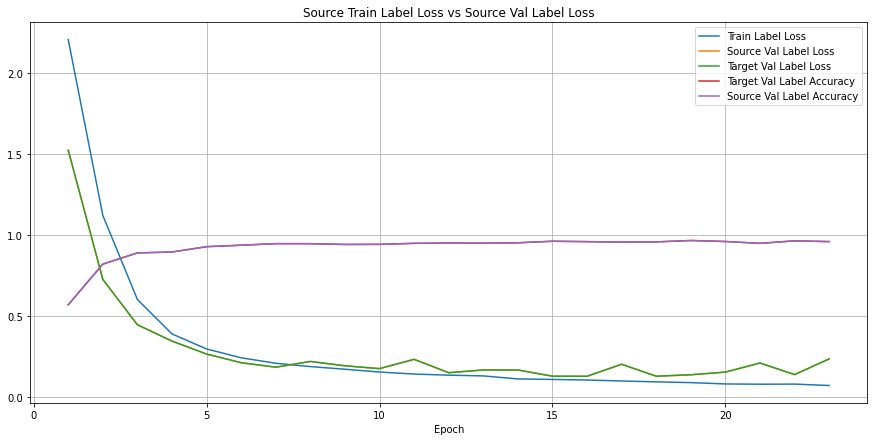

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

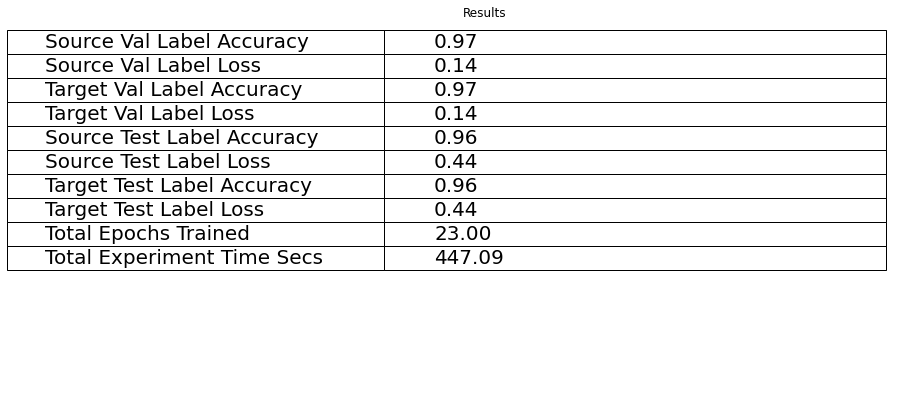

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

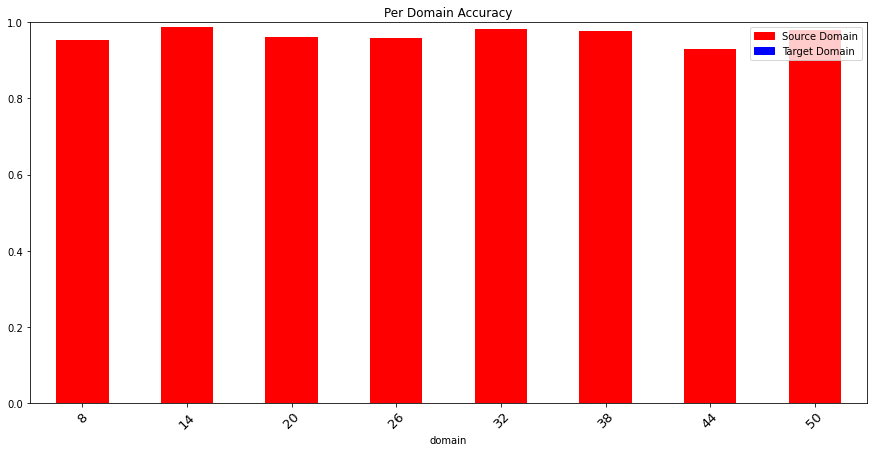

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9647135416666667 Target Test Label Accuracy: 0.9647135416666667
Source Val Label Accuracy: 0.966015625 Target Val Label Accuracy: 0.966015625


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1.framed", "parameters": {"experiment_name": "cnn_2:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch